In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot(lon,lat,var,levels,cmap,vmin,vmax,title,tick_locs,tick_labels,cb_label,log=True,labelpad=25):
    varlist=[var]
    fig = plt.figure(figsize=(12, 6))
        
    xticks = np.arange(0,360+60,60)
    yticks = np.arange(-80,80+20,20)

    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=0.5)

    ax.set_xlim(0,360)
    ax.set_ylim(-80,80)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both',labelsize=16)
    
    if log==True:
        p1 = ax.contourf(lon, lat, globals()[var], levels=levels, cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), extend="both")
    else:
        p1 = ax.contourf(lon, lat, globals()[var], levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, extend="both")
    # transform=ccrs.PlateCarree()
    ax.set_title(title,fontsize=20)
    
    ax_cb = plt.axes([0.87, 0.14, 0.01, 0.66])   
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(cb_label,fontsize=20,rotation=270,labelpad=labelpad);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    ax.set_position([0.1,0.1,0.75,0.75])

In [3]:
g = 9.8
nt = 236
rho0 = 1035.0
radius = 6371e+3
t_19cyc = np.arange(nt)

In [4]:
tpgd = xr.open_dataset('/g/data/nm03/TPXO9v5a/gridtpxo9v5a.nc')
mz_tpxo = np.array(tpgd.mz.transpose().fillna(1))
mz_tpxo[mz_tpxo==0]=np.nan

mu_tpxo = np.array(tpgd.mu.transpose().fillna(1))
mu_tpxo[mu_tpxo==0]=np.nan

mv_tpxo = np.array(tpgd.mv.transpose().fillna(1))
mv_tpxo[mv_tpxo==0]=np.nan

ny, nx  = np.array(tpgd.ny), np.array(tpgd.nx)

omega = np.full((nt,ny.size,nx.size),(2*np.pi/(12.4206014)))
lon_z = np.array(tpgd.lon_z.transpose())/180 *np.pi
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi 
lon_u = np.array(tpgd.lon_u.transpose())/180 *np.pi 
lat_u = np.array(tpgd.lat_u.transpose())/180 *np.pi 
lon_v = np.array(tpgd.lon_v.transpose())/180 *np.pi 
lat_v = np.array(tpgd.lat_v.transpose())/180 *np.pi 

In [5]:
dlat = lat_z[1,0]-lat_z[0,0]
dlon = lon_z[0,1]-lon_z[0,0]

In [6]:
print(dlat,dlon)

0.0029088821687774935 0.0029088821688334787


In [7]:
depth = tpgd.hz.transpose()
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
fac_dep = xr.where(depth_z > 500, 1, 0) 
lat_z_deg = np.array(tpgd.lat_z.transpose())
lon_z_deg = np.array(tpgd.lon_z.transpose())

depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_z_deg),
                              'lat': (('yh', 'xh'), lat_z_deg)})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [8]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO9v5a/h_tpxo9.v5a.nc')
elev_a = mz_tpxo * np.array(tpxo.ha.isel({'nc':0}).transpose())
elev_p = mz_tpxo * np.array(tpxo.hp.isel({'nc':0}).transpose())/180 *np.pi
elev_tpxo = (elev_a[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - elev_p[None,:,:]))).real

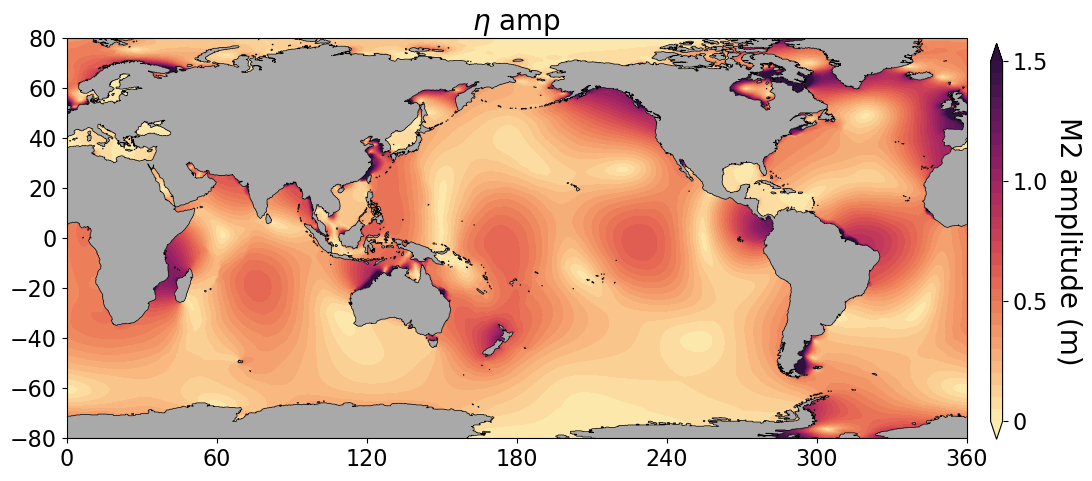

In [9]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(0,1.5+0.05,0.05)
tick_locs = np.arange(0,1.5+0.5,0.5)
tick_labels = np.array(["0","0.5","1.0","1.5"])
plot(lon,lat,'elev_a',levels,cm.cm.matter,0,1.5,'$\eta$ amp',tick_locs,tick_labels,'M2 amplitude (m)',log=False,labelpad=25)

In [10]:
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO9v5a/u_tpxo9.v5a.nc')

ua = mu_tpxo * np.array(tpxo_vel.ua.isel({'nc':0}).transpose())/100
va = mv_tpxo * np.array(tpxo_vel.va.isel({'nc':0}).transpose())/100 

uha = mu_tpxo * np.array(tpxo_vel.Ua.isel({'nc':0}).transpose()) 
vha = mv_tpxo * np.array(tpxo_vel.Va.isel({'nc':0}).transpose()) 

up = mu_tpxo * np.array(tpxo_vel.up.isel({'nc':0}).transpose())/180 *np.pi 
vp = mv_tpxo * np.array(tpxo_vel.vp.isel({'nc':0}).transpose())/180 *np.pi 

u = (uha[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - up[None,:,:]))).real * fac_dep
v = (vha[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - vp[None,:,:]))).real * fac_dep

umag  = np.sqrt(ua**2+va**2)
uhmag = np.sqrt(uha**2+vha**2)

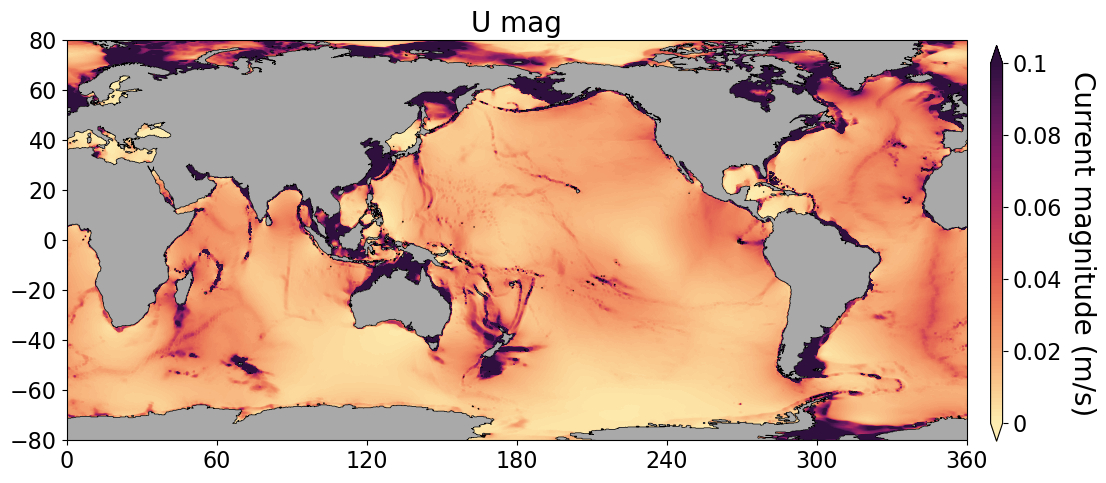

In [11]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels =np.arange(0,0.1+0.001,0.001)
tick_locs = np.arange(0,0.1+0.02,0.02)
tick_labels = np.array(["0","0.02","0.04","0.06","0.08","0.1"])
plot(lon,lat,'umag',levels,cm.cm.matter,0,0.1,'U mag',tick_locs,tick_labels,'Current magnitude (m/s)',log=False,labelpad=25)

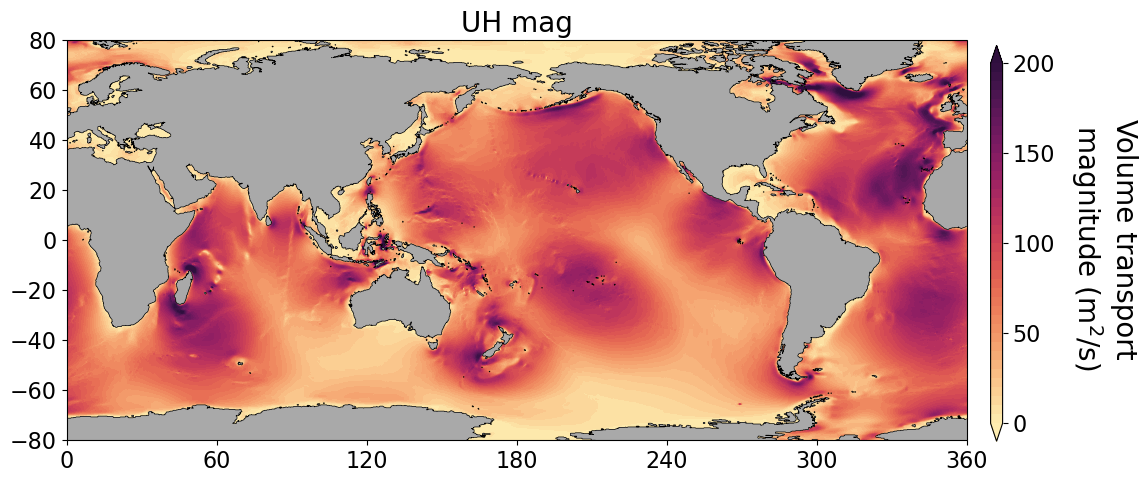

In [12]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels =np.arange(0,200+5,5)
tick_locs = np.arange(0,200+50,50)
tick_labels = np.array(["0","50","100","150","200"])
plot(lon,lat,'uhmag',levels,cm.cm.matter,0,200,'UH mag',tick_locs,tick_labels,'Volume transport \n magnitude (m$^2$/s)',log=False,labelpad=60)

### Interpolate eta to u and v points

In [13]:
start_time = time.time()

ds_elev_z = xr.Dataset(data_vars={"elev_tpxo": (('nt','ny','nx'), elev_tpxo),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z), 
                               "lat": (('ny', 'nx'), lat_z)})
ds_grid_u = xr.Dataset({"lat": (["ny","nx"], lat_u),
                        "lon": (["ny","nx"], lon_u)})
ds_grid_v = xr.Dataset({"lat": (["ny","nx"], lat_v),
                        "lon": (["ny","nx"], lon_v)})

print('regridding z to u')
regridder_z2u = xe.Regridder(ds_elev_z, ds_grid_u, "bilinear", extrap_method="inverse_dist")
print('regridding z to v')
regridder_z2v = xe.Regridder(ds_elev_z, ds_grid_v, "bilinear", extrap_method="inverse_dist")

ds_elev_u = regridder_z2u(ds_elev_z)
ds_elev_v = regridder_z2v(ds_elev_z)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

regridding z to u
regridding z to v
Execution time: 187.8 seconds! 



In [14]:
elev_tpxo_u = np.array(ds_elev_u["elev_tpxo"]) * mu_tpxo
elev_tpxo_v = np.array(ds_elev_v["elev_tpxo"]) * mv_tpxo

In [15]:
veta = np.nanmean( v * elev_tpxo_v * np.cos(lat_v), axis=0 )
ueta = np.nanmean( u * elev_tpxo_u, axis=0 )

dveta = np.full((ny.size,nx.size), np.nan)
dueta = np.full((ny.size,nx.size), np.nan)

dueta[:,:-1] = (ueta[:,1:] - ueta[:,:-1]) / dlon 
dueta[:,-1] = (ueta[:,0] - ueta[:,-1]) / dlon 

dveta[:-1,:] = (veta[1:,:] - veta[:-1,:]) / dlat
dveta[-1,:] = (0 - veta[-1,:]) / dlat

divP1 = 1/( radius*np.cos(lat_z) ) * dveta 
divP2 = 1/( radius*np.cos(lat_z) ) * dueta     

In [16]:
print(np.nanmin(veta),np.nanmax(veta))
print(np.nanmin(ueta),np.nanmax(ueta))
print(np.nanmin(divP1),np.nanmax(divP1))
print(np.nanmin(divP2),np.nanmax(divP2))

-100.30381306001925 75.27814009979603
-242.339053190385 91.16626173566546
-0.6048164515935514 0.5901353075501505
-1.4194544596299918 0.6126269079859951


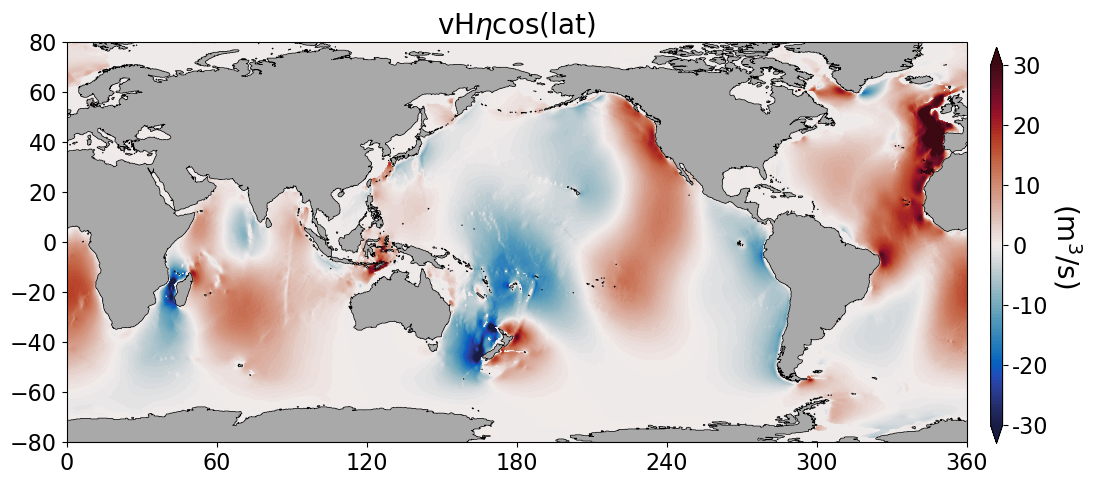

In [17]:
lon = np.rad2deg(lon_v)
lat = np.rad2deg(lat_v)
levels = np.arange(-30,30+0.5,0.5)
tick_locs = np.arange(-30,30+10,10)
tick_labels = np.arange(-30,30+10,10)
plot(lon,lat,'veta',levels,cm.cm.balance,-30,30,'vH$\eta$cos(lat)',tick_locs,tick_labels,'(m$^3$/s)',log=False,labelpad=25)

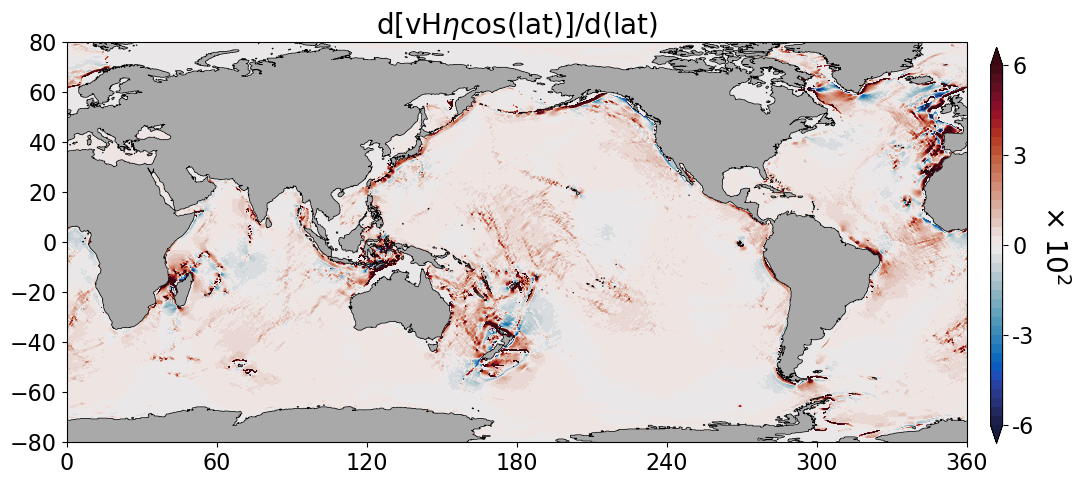

In [18]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-600,600+30,30)
tick_locs = np.arange(-600,600+300,300)
tick_labels = np.array(["-6","-3","0","3","6"])
plot(lon,lat,'dveta',levels,cm.cm.balance,-6e+2,6e+2,'d[vH$\eta$cos(lat)]/d(lat)',tick_locs,tick_labels,r'$\times$ 10$^{2}$',log=False,labelpad=25)

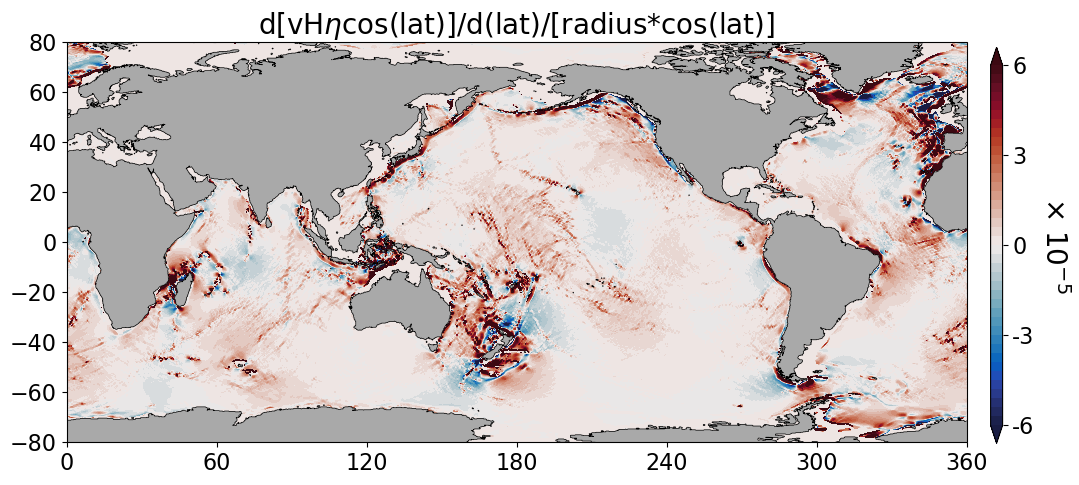

In [19]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-6e-5,6e-5+3e-6,3e-6)
tick_locs = np.arange(-6e-5,6e-5+3e-5,3e-5)
tick_labels = np.array(["-6","-3","0","3","6"])
plot(lon,lat,'divP1',levels,cm.cm.balance,-6e-5,6e-5,'d[vH$\eta$cos(lat)]/d(lat)/[radius*cos(lat)]',tick_locs,tick_labels,r'$\times$ 10$^{-5}$',log=False,labelpad=25)

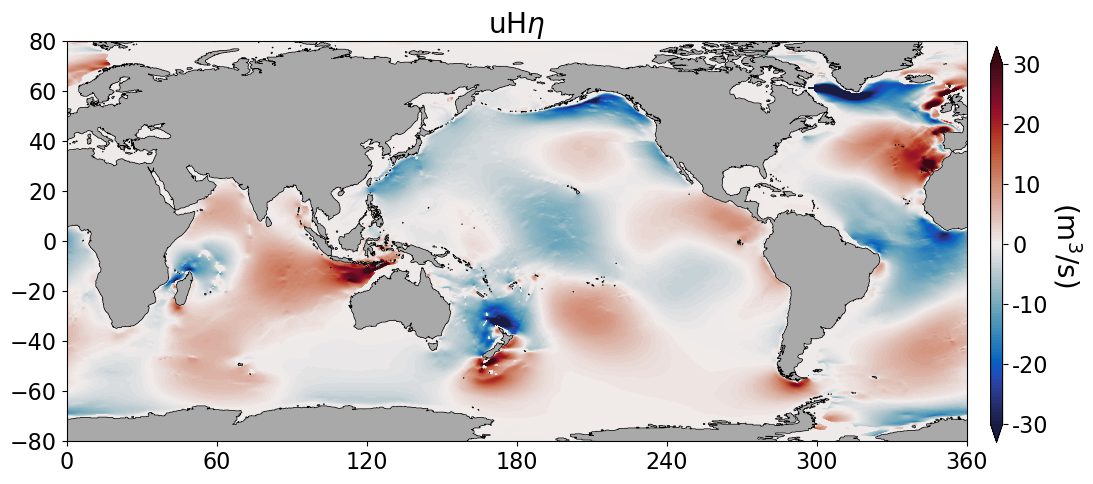

In [20]:
lon = np.rad2deg(lon_u)
lat = np.rad2deg(lat_u)
levels = np.arange(-30,30+0.5,0.5)
tick_locs = np.arange(-30,30+10,10)
tick_labels = np.arange(-30,30+10,10)
plot(lon,lat,'ueta',levels,cm.cm.balance,-30,30,'uH$\eta$',tick_locs,tick_labels,'(m$^3$/s)',log=False,labelpad=25)

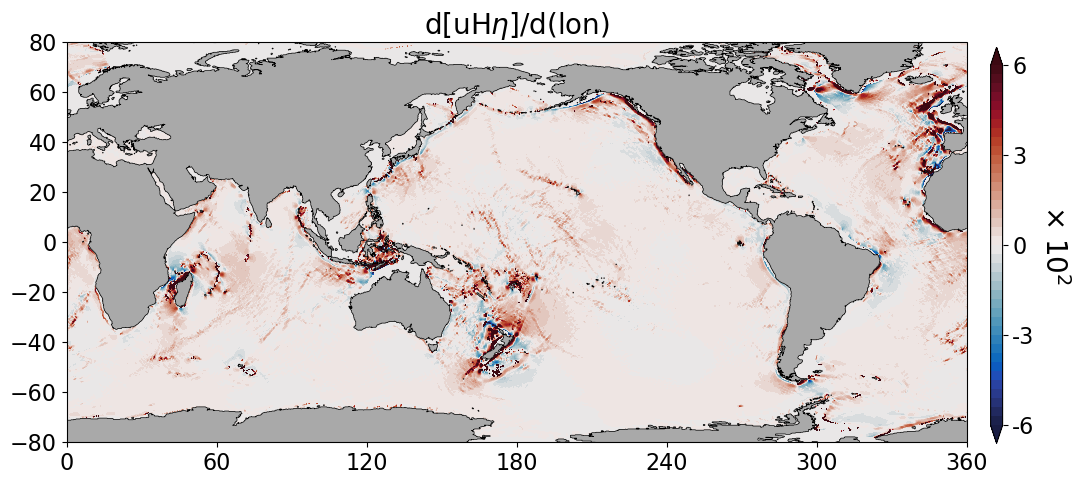

In [21]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-600,600+30,30)
tick_locs = np.arange(-600,600+300,300)
tick_labels = np.array(["-6","-3","0","3","6"])
plot(lon,lat,'dueta',levels,cm.cm.balance,-6e+2,6e+2,'d[uH$\eta$]/d(lon)',tick_locs,tick_labels,r'$\times$ 10$^{2}$',log=False,labelpad=25)

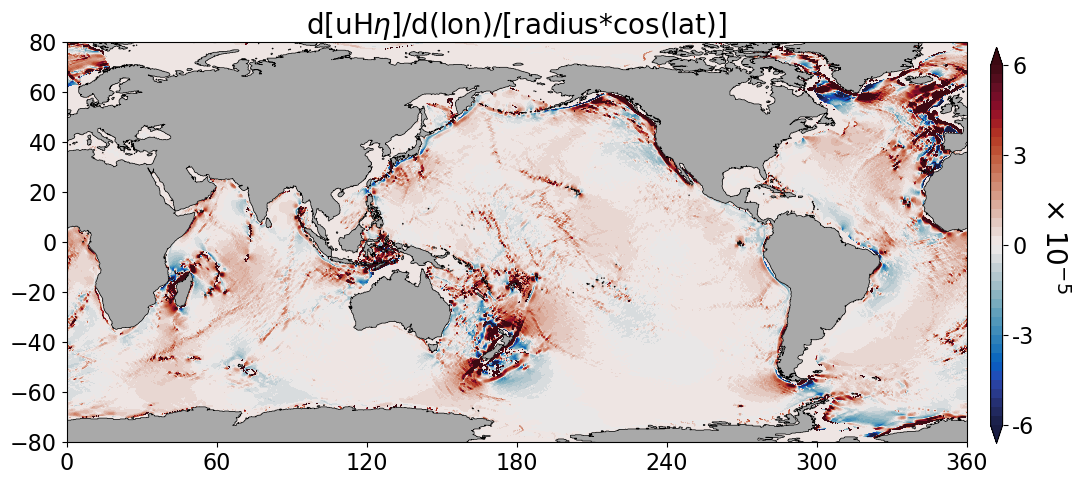

In [22]:
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-6e-5,6e-5+3e-6,3e-6)
tick_locs = np.arange(-6e-5,6e-5+3e-5,3e-5)
tick_labels = np.array(["-6","-3","0","3","6"])
plot(lon,lat,'divP2',levels,cm.cm.balance,-6e-5,6e-5,'d[uH$\eta$]/d(lon)/[radius*cos(lat)]',tick_locs,tick_labels,r'$\times$ 10$^{-5}$',log=False,labelpad=25)

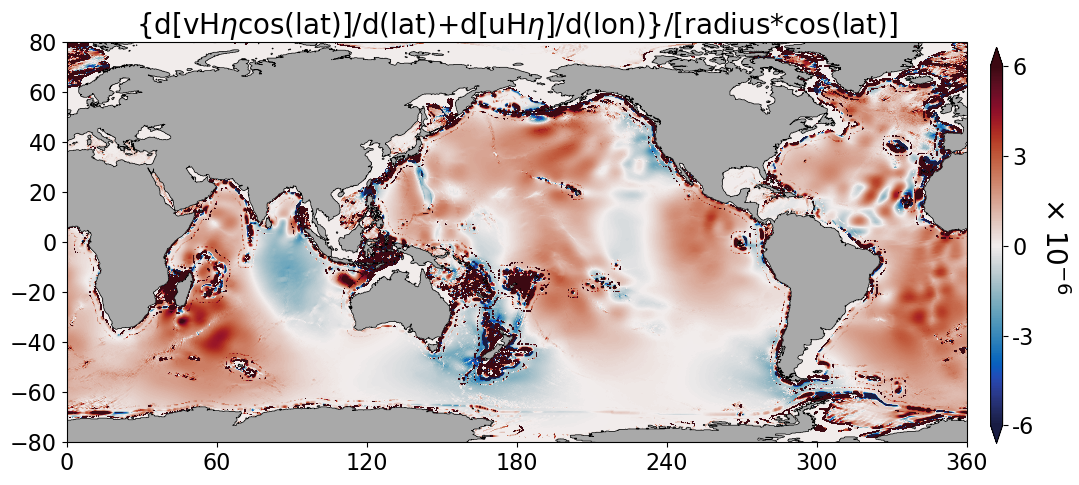

In [23]:
divP = divP1 + divP2
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-6e-6,6e-6+3e-8,3e-8)
tick_locs = np.arange(-6e-6,6e-6+3e-6,3e-6)
tick_labels = np.array(["-6","-3","0","3","6"])
plot(lon,lat,'divP',levels,cm.cm.balance,-6e-6,6e-6,'{d[vH$\eta$cos(lat)]/d(lat)+d[uH$\eta$]/d(lon)}/[radius*cos(lat)]',tick_locs,tick_labels,r'$\times$ 10$^{-6}$',log=False,labelpad=25)

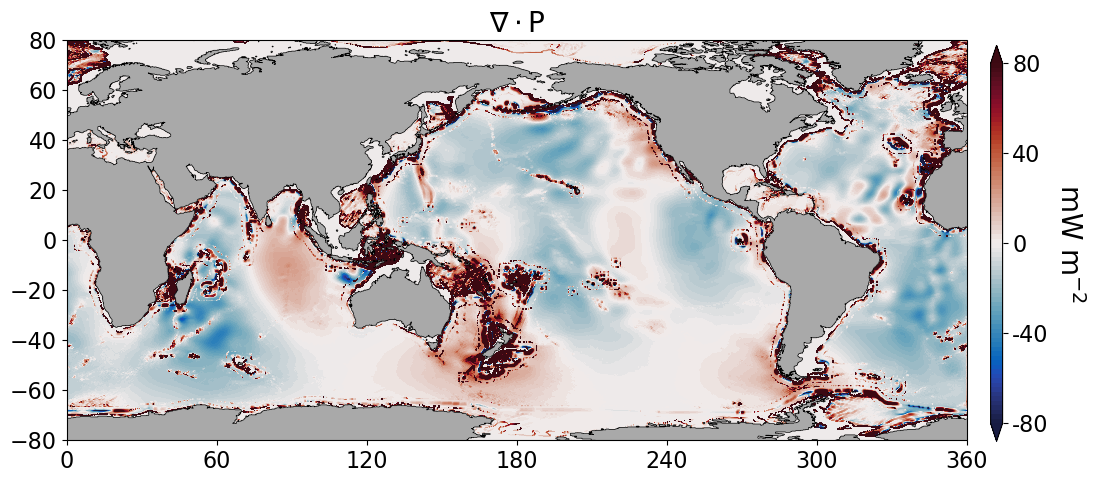

In [24]:
P = -g * rho0 * divP *1000
lon = np.rad2deg(lon_z)
lat = np.rad2deg(lat_z)
levels = np.arange(-0.8,0.8+0.02,0.02)*100
tick_locs = np.arange(-0.8,0.8+0.4,0.4)*100
tick_labels = np.array(["-80","-40","0","40","80"])
plot(lon,lat,'P',levels,cm.cm.balance,-80,80,r'$\nabla\cdot$P',tick_locs,tick_labels,'mW m$^{-2}$',log=False,labelpad=25)

In [25]:
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi
dA = radius**2 * np.cos(lat_z) * (-dlat) * dlon * mz_tpxo
print(np.nanmin(dA),np.nanmax(dA))

-343453122.4954827 15.230414246249


In [26]:
global_fluxes = np.nansum(P*dA)/1000/1e+12
deep_fluxes = np.nansum(P*dA*fac_dep)/1000/1e+12
print('Global M2 tidal energy fluxes: %.4fTW'%global_fluxes)
print('> 500m M2 tidal energy fluxes: %.4fTW'%deep_fluxes)

Global M2 tidal energy fluxes: -0.0052TW
> 500m M2 tidal energy fluxes: 0.3083TW


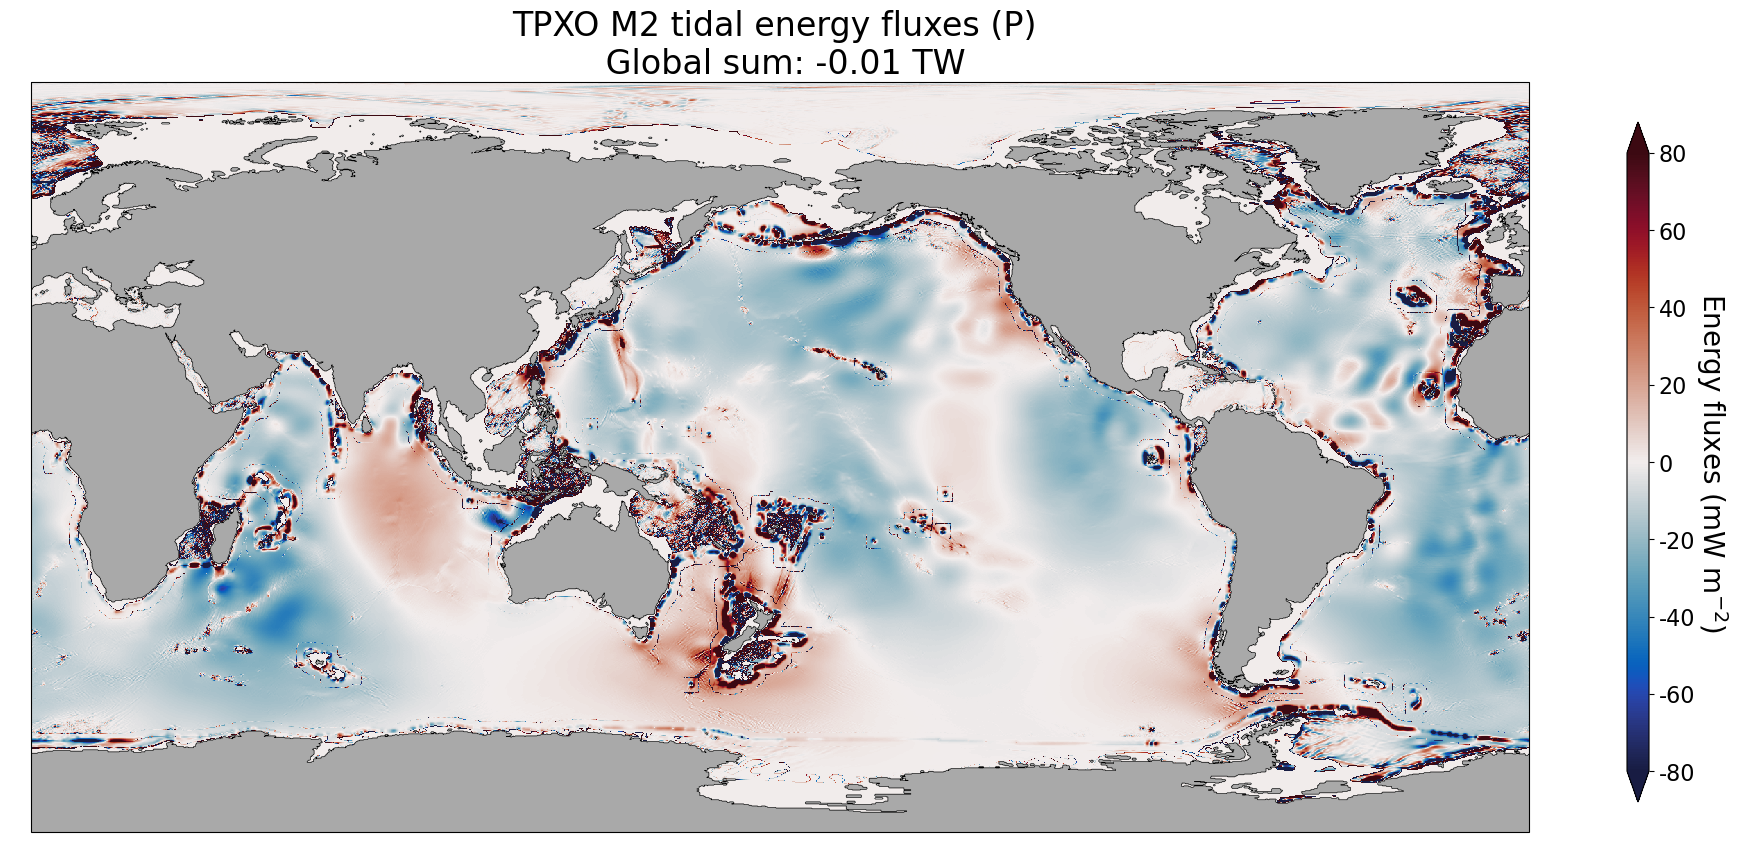

In [27]:
varlist = ['P']

title   = ['TPXO M2 tidal energy fluxes (P) \n Global sum: %.2f TW'%(global_fluxes)]
tick_locs = np.array([-80,-60,-40,-20,0,20,40,60,80])
tick_labels = np.array(["-80","-60","-40","-20","0","20","40","60","80"])

fig = plt.figure(figsize=(22, 10))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(lon_z_deg, lat_z_deg, globals()[var],  cmap=cm.cm.balance, vmin=-80, vmax=80)
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.86, 0.13, 0.01, 0.68])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy fluxes (mW m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    if I==0:
        ax.set_position([0.1,0.1,0.75,0.75])
        
# plt.savefig('/g/data/nm03/lxy581/exps_figs/TPXO_M2_P_lin.png', dpi=100, bbox_inches='tight')